# VALUE vs GROWTH DETECTION

This notebook contains all the code that will produce a model/signal to predict the optimum shift between value or growth investing.

_IMPORTS_

In [1]:
import os
import json
import pickle
import dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### _LOAD DATA_

In [2]:
root_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(root_dir, "data")
dotenv_file = os.path.join(root_dir, '.env')

#loading all etfs data
etfs_dict = {}
for f in os.listdir(os.path.join(DATA_DIR, "etf_data")):
    if f.startswith("SPY"):
        etfs_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "etf_data", f))

with open (os.path.join(DATA_DIR, "etf_data", "us_etfs_list.pkl"), "rb") as f:
    etfs_list : dict = pickle.load(f)

#Load Commodities Futures Prices: .csv
commodities_dict = {}
commodities_files = os.listdir(os.path.join(DATA_DIR, "commodities"))
for f in commodities_files:
    commodities_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "commodities", f))

#Load Currencies Prices: .csv
currencies_dict = {}
currencies_files = os.listdir(os.path.join(DATA_DIR, "currencies"))
for f in currencies_files:
    currencies_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "currencies", f))

#FEDFUNDS and BALANCE: .pkl
macro_files = os.listdir(os.path.join(DATA_DIR, "macro_data"))
with open(os.path.join(DATA_DIR, "macro_data", "macro_data.pkl"), "rb") as f:
    macro_dict = pickle.load(f)


### EDA & Feature Eng

_Create Dataframes_

In [162]:
start, end = "2014-05-01", "2024-05-01"
daterange = pd.date_range(start=start, end=end, freq="d").strftime("%Y-%m-%d")
period = 258

etfs = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "etf_data")) if i.startswith("SPY")]
etfs_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "etf_data",f"{i}.csv"),index_col="Date") for i in etfs],
    axis=1,
)
etfs_df.columns = etfs
etfs_df = np.log(etfs_df / etfs_df.shift(period))
etfs_df = etfs_df[(etfs_df.index >= start) & (etfs_df.index <= end)]
#-------------------------------------------------------------------------------------------------------------
currencies = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "currencies"))]
curr_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "currencies",f"{i}.csv"), index_col="Date") for i in currencies],
    axis=1,
)
curr_df.columns = currencies
curr_df = np.log(curr_df/curr_df.shift(period))
curr_df = curr_df[(curr_df.index >= start) & (curr_df.index <= end)]
# #-------------------------------------------------------------------------------------------------------------
macro_ind = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "macro_data")) if i.endswith(".csv")]
macro_df = pd.read_csv(os.path.join(DATA_DIR,"macro_data", "FEDFUNDS.csv"),index_col="Date")
macro_df = np.log(macro_df/macro_df.shift(1))
macro_df.columns = macro_ind
# #-------------------------------------------------------------------------------------------------------------
comm = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "commodities")) if i.endswith(".csv")]
commodities_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "commodities", f"{i}.csv"),index_col="Date")["Close"] for i in comm],
    axis=1,
)
commodities_df = np.log(commodities_df/commodities_df.shift(period))
commodities_df = commodities_df[(commodities_df.index >= start) & (commodities_df.index <= end)]
commodities_df.columns = comm
# #-------------------------------------------------------------------------------------------------------------
#Set common indexes
all_data = pd.DataFrame(index=daterange)
all_data = all_data.merge(etfs_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(commodities_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(curr_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(macro_df, left_index=True, right_index=True, how="left")
all_data.index.name = "Date"
all_data.fillna(method="ffill", inplace=True)

all_data["midpoint"] = (all_data["SPYG"] + all_data["SPYV"]) / 2


c:\Users\rvarg\github\rvargas42\Value_Growth_Challenge_ETSFactory\.venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\rvarg\AppData\Local\Temp\ipykernel_13252\2763244727.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method="ffill", inplace=True)


_Visualize Data_

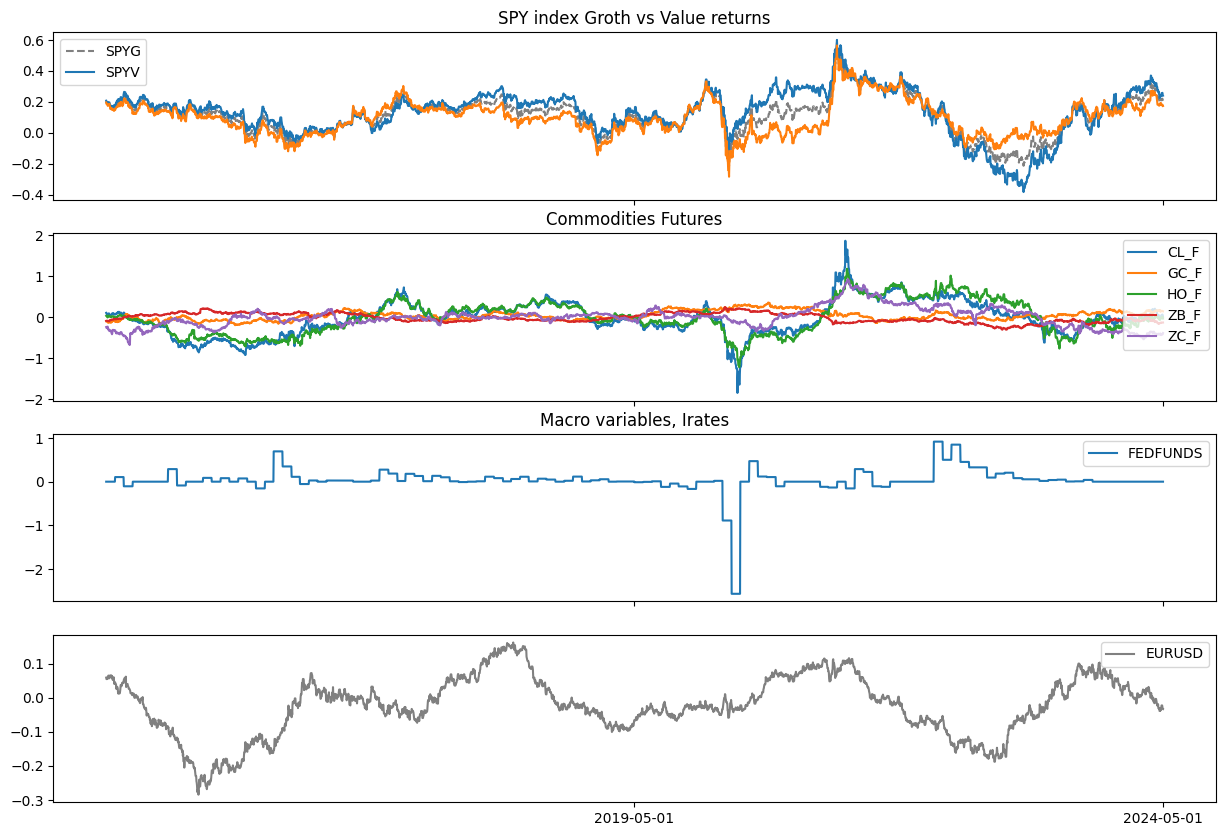

In [163]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 10), sharex=True)

#ETFs
SPYG = all_data.SPYG
SPYV = all_data.SPYV
SPY_midpoint = (SPYG + SPYV) / 2
axs[0].plot(SPY_midpoint, color="grey", linestyle="dashed")
axs[0].plot(all_data["SPYG"])
axs[0].plot(all_data["SPYV"])
axs[0].legend(["SPYG", "SPYV"])
axs[0].set_title("SPY index Groth vs Value returns")

#Commodities
for i in comm:
    axs[1].plot(all_data[i])
axs[1].legend(comm)
axs[1].set_title("Commodities Futures")

#Macro
axs[2].plot(all_data["FEDFUNDS"])
axs[2].legend(macro_df.columns)
axs[2].set_title("Macro variables, Irates")

#currencies
axs[3].plot(all_data["EURUSD"], color="grey")
axs[3].legend(curr_df.columns);

plt.xticks(ticks=all_data.index[::-int(len(all_data)/2)])
plt.savefig(os.path.join(root_dir,"charts", "all_features_history.png"))

#### _Statistical Measures_

_Correlation_

<Axes: >

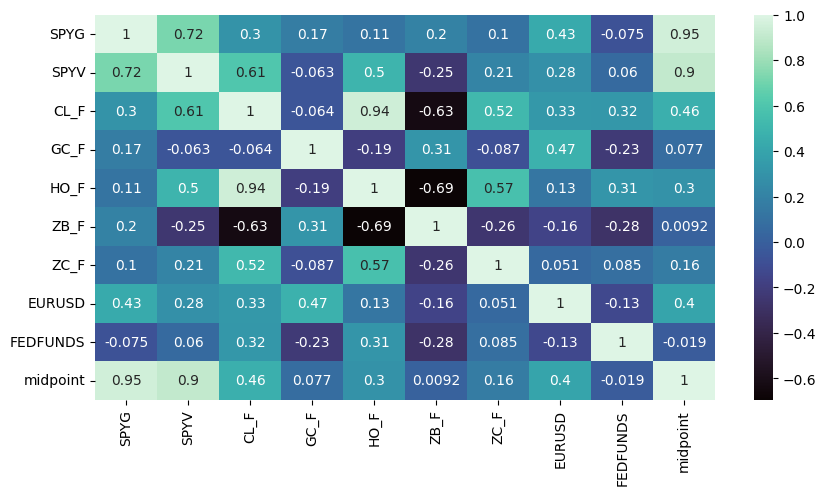

In [164]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(all_data.corr(method="pearson"),cmap="mako",annot=True)

_SPYG vs SPYV Cointegration_

In [165]:
from statsmodels.tsa.stattools import coint

SPYG = all_data.SPYG
SPYV = all_data.SPYV
t_statistic, p_val, critical_p_val = coint(SPYG, SPYV)
print(t_statistic, "\n", p_val, "\n")
alpha = 0.05
if p_val <= alpha:
    print("SPYG and SPYV are NOT cointegrated")
else:
    print("SPYG and SPYV ARE cointegrated")


-2.242112353714001 
 0.40276523698226124 

SPYG and SPYV ARE cointegrated


### _Clasification of Growth/Value Moments_

In [245]:
# seperate both investing styles using the midpoint:
# 1 for growth 0 for value
all_data["momment"] = (SPYG > SPY_midpoint).astype(int)
all_data["midpoint"].shift(15)
all_data.dropna(inplace=True)
y = all_data["midpoint"]
not_features = ["SPYG", "SPYV", "momment", "midpoint"]
features = [i for i in all_data.columns if i not in not_features]
X = all_data[features]

In [246]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from scipy.spatial import distance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [247]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)

In [248]:
print(mean_squared_error(y_test, predictions))

linear_model.coef_
linear_model.feature_names_in_

0.018647817055048938


array(['CL_F', 'GC_F', 'HO_F', 'ZB_F', 'ZC_F', 'EURUSD', 'FEDFUNDS'],
      dtype=object)

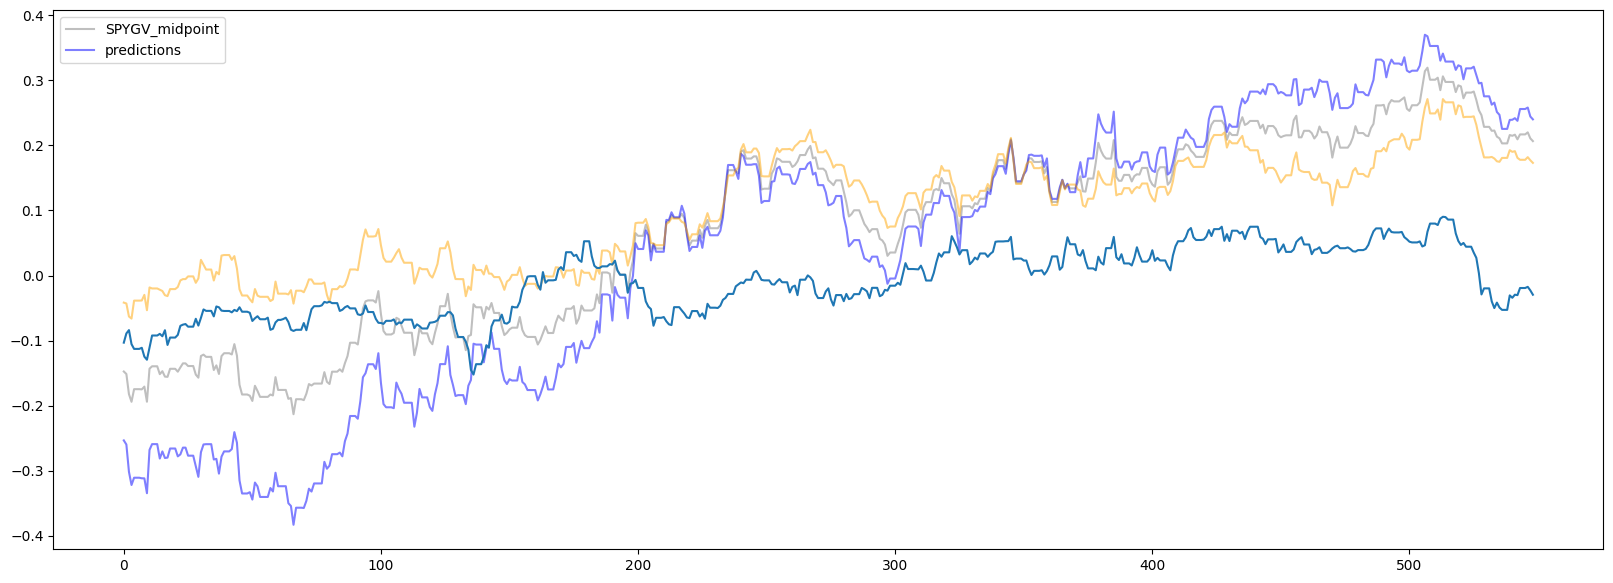

In [249]:
fig = plt.figure(figsize=(20,7))

plt.plot(SPY_midpoint[y_test.index].values, color="grey", alpha=0.5)
plt.plot(SPYG[y_test.index].values, color="blue", alpha=0.5)
plt.plot(SPYV[y_test.index].values, color="orange", alpha=0.5)
plt.plot(predictions)
plt.legend(["SPYGV_midpoint", "predictions"])